# Model1 CNN+LSTM
version 0.1.b.2

## Implementation detals
- Input size: -1 x 2 x 90 x 100
- Output size: -1 x 1
<br></br>
- X: CSI (magnitude + phase)
- Y: side label
## Version Info
- Mapping from CSI to side labels (-1, 0, 1)
- Only uses dynamic data

In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## Model

In [2]:
class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(3, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 100 * 1
            # Out = 30 * 98 * 32
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 30 * 98 * 32
            # Out = 26 * 94 * 64
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 26 * 94 * 64
            # Out = 22 * 90 * 32
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=5, stride=(1, 1), padding=0),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 22 * 90 * 32
            # Out = 18 * 86 * 1
        )

        self.layerfc = nn.Sequential(
            nn.Linear(18*86, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 32)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 18 * 86
        # x = self.dropout(x)
        # x = self.layerfc(x)
        return x


class MyEncodeLSTM(nn.Module):
    def __init__(self):
        super(MyEncodeLSTM, self).__init__()

        self.hidden_size = 128
        self.num_layers = 2

        self.layer = nn.LSTM(36, self.hidden_size, self.num_layers, batch_first=True, dropout=0.1)

    def forward(self, x):
        out, (final_hidden_state, final_cell_state)  = self.layer(x)
        return out


class MyEncoder(nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()
        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()
        self.lstm = MyEncodeLSTM()

    def forward(self, x):
        x = torch.chunk(x.view(-1, 2, 90, 100), 2, dim=1)
        x1 = self.cnn1.forward(x[0])
        x2 = self.cnn2.forward(x[1])

        # size_x = batch_size * 18 * 86

        out = torch.cat([x1, x2], dim=2).transpose(1, 2).view(-1, 86, 36)
        #size_out = batch_size * 128 * 86
        out = self.lstm.forward(out)
        
        return out[:, -1, :]


class MyDecodeFC(nn.Module):
    def __init__(self):
        super(MyDecodeFC, self).__init__()

        self.fclayers = nn.Sequential(
            nn.Linear(128, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),)
        
        self.onehotout = nn.Sequential(
            nn.Linear(4096, 3),
            nn.ReLU(),
            nn.Softmax(dim=1)
         )
        
        self.singleout = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fclayers(x)
        x = self.onehotout(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecodeFC()

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z) 
        return y

In [3]:
m1 = MyModel()
summary(m1, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─MyEncoder: 1-1                         [1, 128]                  --
│    └─MyEncodeCNN: 2-1                  --                        202,400
│    │    └─Sequential: 3-1              [1, 32, 30, 98]           384
│    │    └─Sequential: 3-2              [1, 64, 26, 94]           51,392
│    │    └─Sequential: 3-3              [1, 32, 22, 90]           51,296
│    │    └─Sequential: 3-4              [1, 1, 18, 86]            803
│    └─MyEncodeCNN: 2-2                  --                        202,400
│    │    └─Sequential: 3-5              [1, 32, 30, 98]           384
│    │    └─Sequential: 3-6              [1, 64, 26, 94]           51,392
│    │    └─Sequential: 3-7              [1, 32, 22, 90]           51,296
│    │    └─Sequential: 3-8              [1, 1, 18, 86]            803
│    └─MyEncodeLSTM: 2-3                 --            

## Dataset

In [4]:
# My Dataset

class MyDataset(Data.Dataset):
    def __init__(self, x_path, y_path, number=0):
        self.seeds = None
        self.data = self.load_data(x_path, y_path, number=number)
        print('loaded')

    def __getitem__(self, index):
        return self.data['x'][index], self.data['y'][index]

    def __len__(self):
        return self.data['x'].shape[0]

    def load_data(self, x_path, y_path, number):
        x = np.load(x_path)
        y = np.load(y_path)

        if x.shape[0] == y.shape[0]:
            total_count = x.shape[0]
        else:
            print(x.shape, y.shape, "lengths not equal!")
            
        if number != 0:
            picked = np.random.choice(list(range(total_count)), size=number, replace=False)
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x':x, 'y':y}
    
def split_loader(dataset, train_size, valid_size, test_size, batch_size):
    train_dataset, valid_dataset, test_dataset = Data.random_split(dataset, [train_size, valid_size, test_size])
    print(len(train_dataset), len(valid_dataset), len(test_dataset))
    train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = Data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = Data.DataLoader(test_dataset, batch_size=1, shuffle=True)
    return train_loader, valid_loader, test_loader

In [5]:
datadir = '../Dataset/0208make00/'
print(os.listdir(datadir))

['sid.npy', 'csi.npy', '.ipynb_checkpoints', 'sid2.npy', 'sid_10.npy']


In [11]:
mydata = MyDataset(datadir + 'csi.npy', datadir + 'sid_10.npy')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = split_loader(mydata, train_size, valid_size, test_size, 64)

loaded
(3514, 2, 90, 100) (3514, 3)
2459 702 353
2459 702 353


In [7]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

## Running gears

In [8]:
# Hyperparameters

class MyArgs:
    def __init__(self, epochs=10, learning_rate=0.001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

args = MyArgs(epochs=1000, learning_rate=0.1)

In [9]:
# Model and Loss

model = MyModel().to(args.device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [12]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        outputs = model(data_x)
        loss = criterion(outputs, data_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))
  
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.float32).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

torch.save(model.state_dict(), '../Models/v01b2_ep300.pth')
end = time.time()
print("\nTotal training time:", end-start, "sec")

epoch=999/1000,19/38of train, loss=31.270833969116212
Total training time: 3098.2651178836823 sec


## Visualization of Training Process

In [ ]:
# Plot loss curves

%matplotlib inline
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[1:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [24]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(600,) (2,)
(22800,) (20,)


## Load from checkpoint

In [13]:
# If you want to train from a certain checkpoint

#model = torch.load('../Models/v0_ep500_lr001.pth')
model.load_state_dict(torch.load('../Models/v0_ep500_lr001.pth'))
model.cuda()

# Reload the loss curve
preserve = 500
# 3 iter per epoch
train_loss = train_loss[:preserve * 3]
# discard following epoch values
train_epochs_loss = train_epochs_loss[:preserve]

# re-validate
valid_loss = []
valid_epochs_loss = []

args = MyArgs(epochs=200, learning_rate=0.0001)

AttributeError: Can't get attribute 'MyDecoder' on <module '__main__'>

## Estimation
Test performance

In [14]:
  #=====================test============================
estimate = []
test_loss = []
ground_truth = []
model.eval()
for idx,(data_x,data_y) in enumerate(test_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.float32).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    estimate.append(outputs.cpu().detach().numpy().squeeze().tolist())
    ground_truth.append(data_y.cpu().detach().numpy().squeeze().tolist())
    test_loss.append(loss.item())
    if idx%(len(test_loader)//5)==0:
        print("\r{}/{}of test, loss={}".format(
        idx, len(test_loader),loss.item()), end='')

350/353of test, loss=33.66666793823242

Confusion matrix

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Text(30.5, 0.5, 'true')

<Figure size 432x288 with 0 Axes>

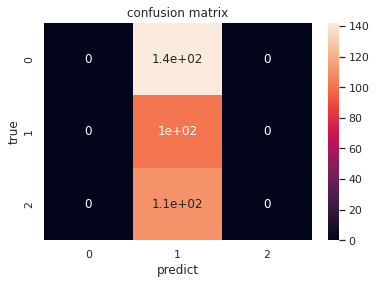

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

def fromonehot(inlist):
    out = []
    for item in inlist:
        if np.argmax(item) == 0:
            out.append(-1)
        elif np.argmax(item) == 1:
            out.append(0)
        elif np.argmax(item) == 2:
            out.append(1)
    return out

print(fromonehot(estimate))

plt.figure()
sns.set()
f,ax=plt.subplots()
cf = confusion_matrix(fromonehot(ground_truth), fromonehot(estimate))

sns.heatmap(cf,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')

In [ ]:
%matplotlib inline
data = torch.tensor(csis, dtype=torch.float32, device='cuda:1')
for i in range(len(data)):
    predictions = model(data[i])
    pred = predictions.cpu().detach().numpy()[0, 0]
    plt.figure()
    plt.imshow(pred)
    plt.show()